In [0]:
%%capture
!pip install parameter-sherpa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sherpa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot

import logging 
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logger.info("IS_CRITICAL uuuhh")

torch.__version__

'1.3.1'

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
path = "drive/My Drive/AML/"
#path = ""

df = pd.read_csv(path + "pmsm_temperature_data.csv")

In [12]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


In [0]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque','stator_yoke',
                                           'stator_tooth','stator_winding'], 
                                          axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

In [0]:
class GRU_Net(nn.Module):
    def __init__(self, features, hidden, h1, h2, out):
        super(GRU_Net, self).__init__()
        self.h1 = h1
        self.h2 = h2

        self.hidden_size = hidden
        self.features = features

        self.gru = nn.GRU(self.features, self.hidden_size, 1, #feature_size, hidden_size, num_layer
                            batch_first = True) 
        self.fc1 = nn.Linear(self.hidden_size, 
                                h1)
        self.out = nn.Linear(h1, out)

        if self.h2 != 0:
            self.fc2 = nn.Linear(h1, h2)
            self.out = nn.Linear(h2, out)
        
        #we do it stateless so there is no need for the hidden_state
        #self.hidden = None #torch.randn(1, ??, self.hidden) #num_layer, batch, hidden_size

    def forward(self, x):
        batch_size, _, _ = x.shape 
        
        x, _ =  self.gru(x)
        x = F.tanh(x[:,-1].view(batch_size, -1))
        
        x = F.relu(self.fc1(x))
        if self.h2 != 0:
            x = F.relu(self.fc2(x))
        return self.out(x)

In [0]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7]

In [0]:
def dataloader(data, length, shuffle=True, out=1):
    while True:
    # genera una lista di (i_serie, i_obs)
        tuples = [[(df_i, i) for i, x in enumerate(data[df_i]) if i >= length + out]
                  for df_i, _ in enumerate(data)]
        tuples = sum(tuples, [])  # flattenizza
        # shuffle
        if shuffle:
            np.random.shuffle(tuples)

        # yielda le osservazioni
        for df_i, i in tuples:
            X_lagged = data[df_i][(i - length - out):(i - out), FEATURES + TARGET]
            y = data[df_i][(i-out):(i), TARGET]
            yield X_lagged, y

In [0]:
train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'stator_yoke','stator_tooth',
                                                                                  'stator_winding'], 
                                                                                 axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'stator_yoke','stator_tooth',
                                                                                  'stator_winding'], 
                                                                                 axis=1).max()

In [0]:
df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [0]:
parameters = [sherpa.Discrete('gru_hidden',[20,80]),
              sherpa.Discrete('hidden_unit1',[16,64]),
              sherpa.Discrete('hidden_unit2',[0,64]),
              sherpa.Continuous('lr',[0.005,0.05]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [0]:
look_back = 60
best_score = 99999

for trial in study:

    lstm = GRU_Net(features=8, hidden=int(trial.parameters["gru_hidden"]), 
                  h1=int(trial.parameters["hidden_unit1"]), 
                  h2=int(trial.parameters["hidden_unit2"]),out=1).to(device)
    
    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    #gen = sliding_window(df_train, "pm", look_back, 1)
    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = tqdm(range(0, df_length, batch_size))

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                #gen = sliding_window(df_train, "pm", look_back, 1)
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, look_back, 8)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break
        if len(losses)>100:
            progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses[-100]),7)))
        else:
            progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses),7)))

    #test_gen = sliding_window(df_val, "pm", look_back, 1)
    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back, 8)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_gru")
        print("New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_GRU.csv")

In [0]:
best_model = torch.load(path + "models/best_model_gru")
results = pd.read_csv(path + "results/AutoML_GRU.csv")
results = results[results["Status"]=="COMPLETED"]

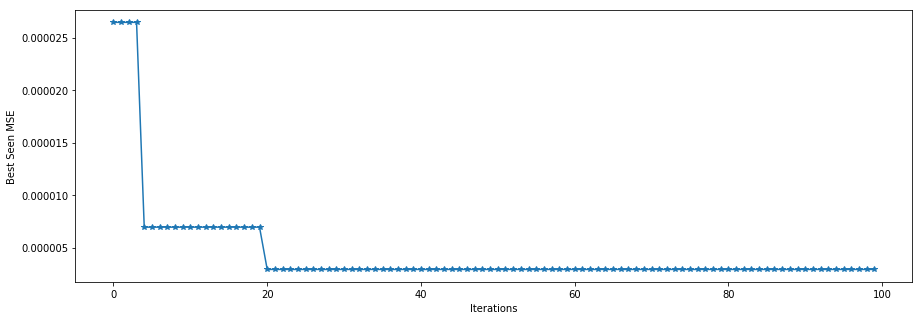

In [0]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
look_back  = 60

test_gen = dataloader([df.values for df in df_test], look_back, shuffle=False)
size = np.sum(df.shape[0] for df in df_test)

batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, look_back, 8)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

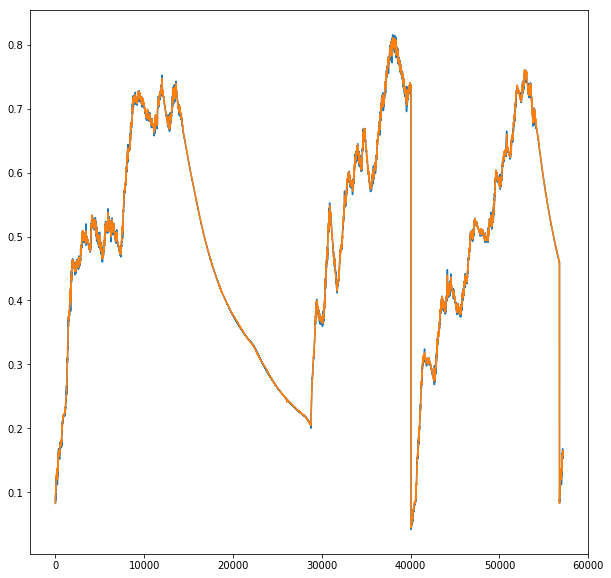

In [0]:
y_test = np.array(y_test).reshape(-1)
plt.figure(figsize=(10,10))
plt.plot(y_test[:])
plt.plot(y_pred_all[:])

plt.show()

In [0]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test)))

0.0029967209454927965

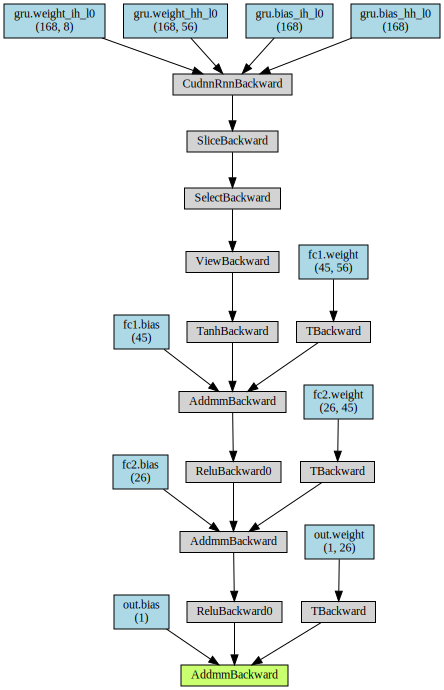

In [0]:
make_dot(best_model(torch.tensor(X.reshape(-1,look_back,8),dtype=torch.float32).to(device)), 
         params=dict(best_model.named_parameters()))

# New Loss

In [0]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque'], 
                                          axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], 
                                                                                 axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], 
                                                                               axis=1).max()

df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]


FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7, 8, 9, 10]

In [0]:
def new_loss(w1=1, w2=1):
    "w1 is the weight for lower temperature and w2 for the upper So w1 <= w2"
    def high_low_loss(output, target):
        weights = w1 + (w2 - w1)*F.relu(target - 0.5)
        return torch.mean(weights*((output - target)**2))
    
    return high_low_loss

In [0]:
parameters = [sherpa.Discrete('gru_hidden',[20,80]),
              sherpa.Discrete('hidden_unit1',[16,64]),
              sherpa.Discrete('hidden_unit2',[0,64]),
              sherpa.Continuous('lr',[0.005,0.05]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [26]:
look_back = 60
best_score = 99999

for trial in study:

    lstm = GRU_Net(features=11, hidden=int(trial.parameters["gru_hidden"]), 
                  h1=int(trial.parameters["hidden_unit1"]), 
                  h2=int(trial.parameters["hidden_unit2"]),out=4).to(device)
    
    losses = []
    criterion = new_loss(1,3)
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    #gen = sliding_window(df_train, "pm", look_back, 1)
    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = range(0, df_length, batch_size)

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, look_back, 11)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  
            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break

    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back, 11)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    #score = np.mean((y_test - y_pred_all)**2) #MSE
    score = np.mean(criterion(torch.tensor(y_pred_all), 
                              torch.tensor(y_test)).item())
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_gru_new_loss")
        print("ID:",trial.id,"New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_GRU_new_loss.csv")

ID: 1 New Challanger with MSE on val: 0.05791774190715475 and confs: {'gru_hidden': 43, 'hidden_unit1': 43, 'hidden_unit2': 3, 'lr': 0.046791570283897944, 'batch_size': 512}
ID: 2 New Challanger with MSE on val: 9.713201717194311e-05 and confs: {'gru_hidden': 79, 'hidden_unit1': 37, 'hidden_unit2': 51, 'lr': 0.031339146791592234, 'batch_size': 1024}
ID: 3 New Challanger with MSE on val: 4.751459742294283e-05 and confs: {'gru_hidden': 45, 'hidden_unit1': 32, 'hidden_unit2': 30, 'lr': 0.01774331549598672, 'batch_size': 1024}
ID: 8 New Challanger with MSE on val: 3.981380956894314e-05 and confs: {'gru_hidden': 61.0, 'hidden_unit1': 53.0, 'hidden_unit2': 57.0, 'lr': 0.005, 'batch_size': 1024.0}
ID: 31 New Challanger with MSE on val: 3.812173327397181e-05 and confs: {'gru_hidden': 44.0, 'hidden_unit1': 18.0, 'hidden_unit2': 64.0, 'lr': 0.005, 'batch_size': 1024.0}
ID: 33 New Challanger with MSE on val: 3.178971410274985e-05 and confs: {'gru_hidden': 20.0, 'hidden_unit1': 64.0, 'hidden_unit2

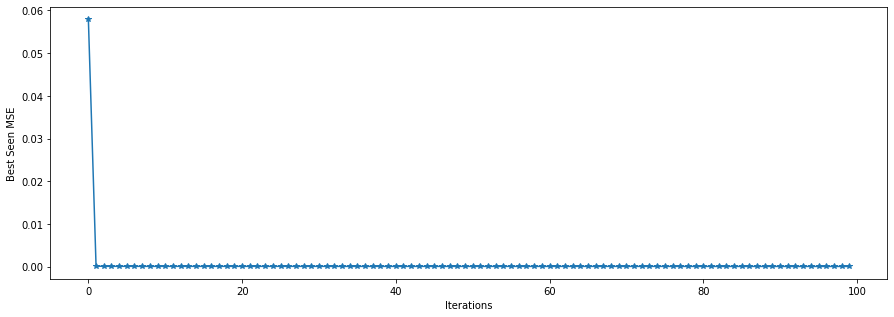

In [27]:
best_model = torch.load(path + "models/best_model_gru_new_loss")
results = pd.read_csv(path + "results/AutoML_GRU_new_loss.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
look_back  = 60

test_gen = dataloader([df.values for df in df_test], look_back, shuffle=False)
size = np.sum(df.shape[0] for df in df_test)
batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break
    inpt = np.array(X_test).reshape(-1, look_back, 11)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

y_pred_all = y_pred_all.reshape(-1,4)
y_test = np.array(y_test).reshape(-1,4)

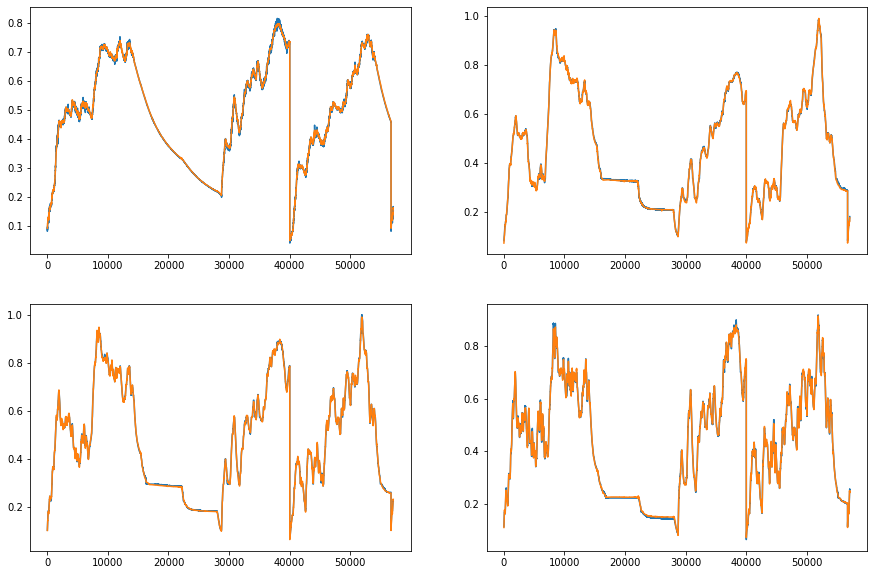

In [30]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(y_test[:,0])
plt.plot(y_pred_all[:,0])

plt.subplot(222)
plt.plot(y_test[:,1])
plt.plot(y_pred_all[:,1])

plt.subplot(223)
plt.plot(y_test[:,2])
plt.plot(y_pred_all[:,2])

plt.subplot(224)
plt.plot(y_test[:,3])
plt.plot(y_pred_all[:,3])
plt.show()

In [31]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test)))

0.009048108845913954

In [0]:
# Stator Variables

In [0]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque','pm'], 
                                          axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

In [0]:
df_sep[0]

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,1.029572,-0.245860,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,1.029509,-0.245832,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,1.029448,-0.245818,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,1.032845,-0.246955,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,1.031807,-0.246610,-1.830498,-2.062795,-2.018145
...,...,...,...,...,...,...,...,...,...,...
33418,0.276746,-1.088478,0.315579,-0.708670,-0.951875,1.029120,-0.245731,-1.747146,-1.985760,-1.971676
33419,0.285366,-1.087670,0.315788,-0.708644,-0.951892,1.029162,-0.245710,-1.747187,-1.985760,-1.971718
33420,0.303218,-1.086620,0.315418,-0.708799,-0.951891,1.029140,-0.245723,-1.747155,-1.985760,-1.970610
33421,0.308903,-1.085028,0.315349,-0.709161,-0.951874,1.029118,-0.245730,-1.747225,-1.985760,-1.970954


In [0]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7,8,9]

In [0]:
train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'pm'], 
                                                                                 axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'pm'], 
                                                                                 axis=1).max()

In [0]:
df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [0]:
parameters = [sherpa.Discrete('gru_hidden',[20,80]),
              sherpa.Discrete('hidden_unit1',[16,64]),
              sherpa.Discrete('hidden_unit2',[0,64]),
              sherpa.Continuous('lr',[0.005,0.05]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [0]:
look_back = 60
best_score = 99999

for trial in study:

    lstm = GRU_Net(features=10, hidden=int(trial.parameters["gru_hidden"]), 
                  h1=int(trial.parameters["hidden_unit1"]), 
                  h2=int(trial.parameters["hidden_unit2"]),out=3).to(device)
    
    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    #gen = sliding_window(df_train, "pm", look_back, 1)
    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = tqdm(range(0, df_length, batch_size))

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                #gen = sliding_window(df_train, "pm", look_back, 1)
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, look_back, 10)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(batch_size,-1), y_batch.view(batch_size,-1))  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break
        if len(losses)>10000:
            progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses[-1000,]),7)))
        else:
            progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses),7)))

    #test_gen = sliding_window(df_val, "pm", look_back, 1)
    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back, 10)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_gru_stator")
        print("New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_GRU_stator.csv")

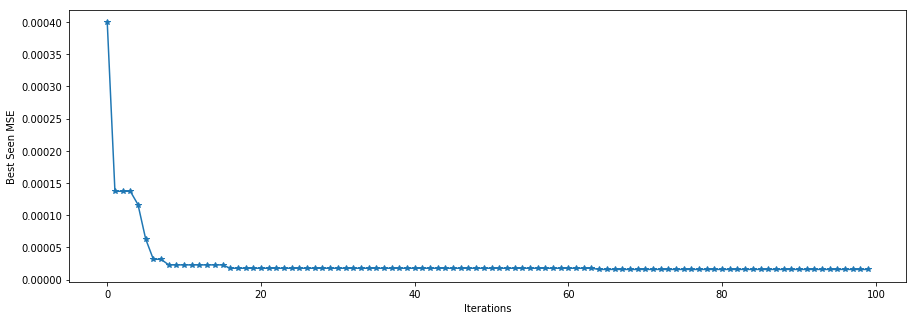

In [0]:
best_model = torch.load(path + "models/best_model_gru_stator")
results = pd.read_csv(path + "results/AutoML_GRU_stator.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
look_back  = 60

test_gen = dataloader([df.values for df in df_test], look_back, shuffle=False)
size = np.sum(df.shape[0] for df in df_test)

batch_size = 510

y_test = []
#y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, look_back, 10)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)
    if x==0:
        y_pred_all = y_pred.cpu().detach().numpy()
    else:
        y_pred_all = np.concatenate((y_pred_all,y_pred.cpu().detach().numpy()))

y_test = np.array(y_test).reshape(-1,3)

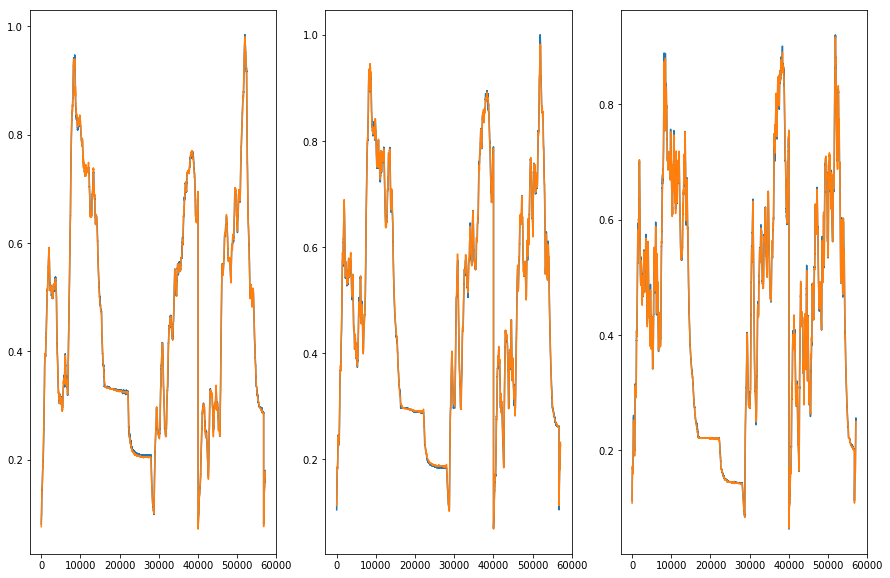

In [0]:
plt.figure(figsize=(15,10))

plt.subplot(131)
plt.plot(y_test[:,0])
plt.plot(y_pred_all[:,0])

plt.subplot(132)
plt.plot(y_test[:,1])
plt.plot(y_pred_all[:,1])

plt.subplot(133)
plt.plot(y_test[:,2])
plt.plot(y_pred_all[:,2])
plt.show()

In [0]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test))) #MAPE

0.007470987217350933

# Regrssion Task

In [0]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque'], 
                                          axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], 
                                                                                 axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], 
                                                                               axis=1).max()

df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [0]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7, 8, 9, 10]

def dataloader(data, length, shuffle=True, out=1):
    while True:
    # genera una lista di (i_serie, i_obs)
        tuples = [[(df_i, i) for i, x in enumerate(data[df_i]) if i >= length + out]
                  for df_i, _ in enumerate(data)]
        tuples = sum(tuples, [])  # flattenizza
        # shuffle
        if shuffle:
            np.random.shuffle(tuples)

        # yielda le osservazioni
        for df_i, i in tuples:
            X_lagged = data[df_i][(i - length - out):(i - out + 1), FEATURES]
            y = data[df_i][(i-out):(i), TARGET]
            yield X_lagged, y
            

def new_loss(w1=1, w2=1):
    "w1 is the weight for lower temperature and w2 for the upper So w1 <= w2"
    def high_low_loss(output, target):
        weights = w1 + (w2 - w1)*F.relu(target - 0.5)
        return torch.mean(weights*((output - target)**2))
    
    return high_low_loss

In [0]:
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

class Reg_CNN_Net(nn.Module):
    def __init__(self, features, 
                 conv1, conv2, conv3, 
                 #conv4, conv5, 
                 conv6,
                 h1, h2, out):
        super(Reg_CNN_Net, self).__init__()
        self.h1 = h1
        self.h2 = h2

        self.features = features

        self.c1 = nn.Conv1d(self.features, conv1, 2)
        self.c2 = nn.Conv1d(conv1, conv2, 2)
        self.c3 = nn.Conv1d(conv2, conv3, 2)
        
        self.c1_r = nn.Conv1d(self.features, conv3, 4)
        
        #self.c4 = nn.Conv1d(conv3, conv4, 2)
        #self.c5 = nn.Conv1d(conv4, conv5, 2)
        #self.c6 = nn.Conv1d(conv5, conv6, 2)
        
        self.c2_r = nn.Conv1d(conv3, conv6, 4)
        
        
        self.seq_len = 21
        h0 = outputSize(outputSize(self.seq_len, 4, 1, 0), 
                        4, 1 ,0)*conv6

        self.fc1 = nn.Linear(h0, h1)
        
        self.out = nn.Linear(h1, out)

        if self.h2 != 0:
            self.fc2 = nn.Linear(h1, h2)
            
            self.out = nn.Linear(h2, out)

    def forward(self, x):
        batch_size, _, _ = x.shape 
        
        x1 = F.tanh(self.c1(x))
        x1 = F.tanh(self.c2(x1))
        x1 = F.tanh(self.c3(x1))
        
        x = F.relu(self.c1_r(x))
        
        x = torch.add(x1, x)
        
        #x1 = F.relu(self.c4(x))
        #x1 = F.relu(self.c5(x1))
        #x1 = F.relu(self.c6(x1))
        
        x = F.relu(self.c2_r(x))
        #x = torch.add(x1, x)

        x = x.view(batch_size,-1)
        
        x = F.relu(self.fc1(x))
        if self.h2 != 0:
            x = F.relu(self.fc2(x))
        return self.out(x)

In [0]:
model = Reg_CNN_Net(7, 3, 5, 7, 7, 16 ,16 , 4)

In [0]:
look_back=20
test_gen = dataloader([df.values for df in df_test], look_back, shuffle=False)
X,y = next(test_gen)
x_torch = torch.tensor(np.swapaxes(X,0,1),dtype=torch.float32).reshape(-1, 7, 21)

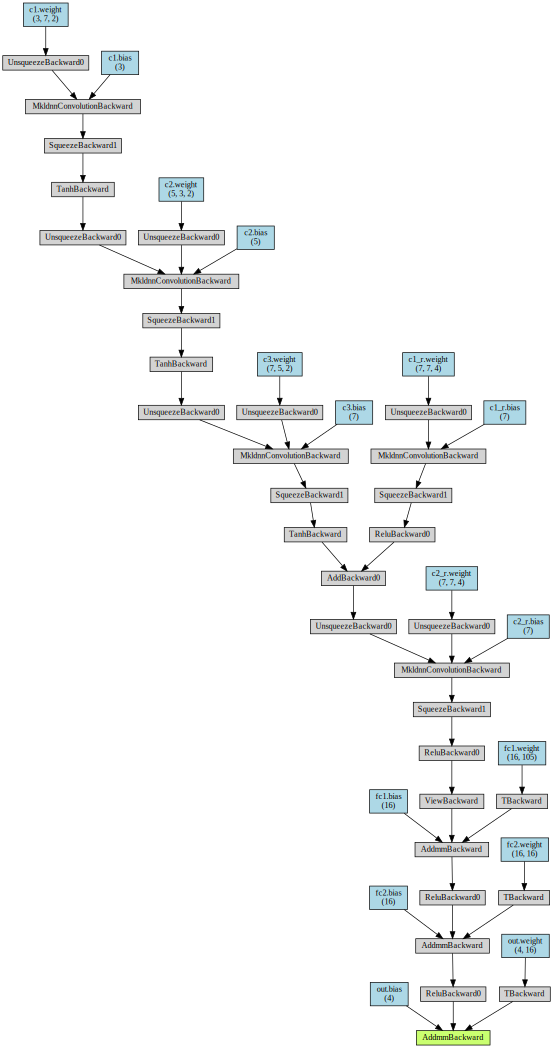

In [0]:
make_dot(model(x_torch), 
         params=dict(model.named_parameters()))

In [0]:
parameters = [sherpa.Continuous('lr',[0.005,0.05]),
              sherpa.Discrete('conv1',[2,5]),
              sherpa.Discrete('conv2',[2,5]),
              sherpa.Discrete('conv3',[2,5]),
              #sherpa.Discrete('conv4',[2,5]),
              #sherpa.Discrete('conv5',[2,7]),
              sherpa.Discrete('conv6',[2,7]),
              sherpa.Discrete('h1',[16,64]),
              sherpa.Discrete('h2',[16,64]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [0]:
look_back  = 20
best_score = 99999
feature    = 7


for trial in study:

    cnn = Reg_CNN_Net(features=feature,
                     conv1 = int(trial.parameters["conv1"]),
                     conv2 = int(trial.parameters["conv2"]),
                     conv3 = int(trial.parameters["conv3"]),
                     conv6 = int(trial.parameters["conv6"]),
                     h1=int(trial.parameters["h1"]),
                     h2=int(trial.parameters["h2"]), out=4).to(device)
                     
    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=trial.parameters["lr"],
                                weight_decay=0.001)

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = range(0, df_length, batch_size)

    cnn.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                #gen = sliding_window(df_train, "pm", look_back, 1)
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(np.swapaxes(X,0,1))
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, feature, look_back + 1)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = cnn(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  
            
            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except Exception as e:
            print("This Happened happened", e)
            print(inpt.shape)
            print(x_batch.size())
            break
        
    
    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    cnn.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(np.swapaxes(X,0,1))
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, feature, look_back + 1)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        #print(x_test_batch.shape)
        y_pred = cnn(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    
    #score = np.mean(criterion(torch.from_numpy(y_pred_all), 
    #                  torch.from_numpy(y_test)).numpy())
    score = np.mean((y_pred_all - y_test)**2)
    if trial.id % 10 == 0:
        print("Now at Trial",trial.id)
    if score < best_score:
        best_score = score
        torch.save(cnn, path + "models/best_model_cnn_reg")
        print("ID:", trial.id,"New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_CNN_reg.csv")

ID: 1 New Challanger with MSE on val: 0.899542801270119 and confs: {'lr': 0.04611359872819951, 'conv1': 4, 'conv2': 2, 'conv3': 2, 'conv6': 6, 'h1': 63, 'h2': 33, 'batch_size': 1024}
ID: 2 New Challanger with MSE on val: 0.8381745675227825 and confs: {'lr': 0.021952511587082123, 'conv1': 3, 'conv2': 3, 'conv3': 2, 'conv6': 4, 'h1': 25, 'h2': 30, 'batch_size': 1024}
ID: 4 New Challanger with MSE on val: 0.8208235446930375 and confs: {'lr': 0.017487498819600655, 'conv1': 3, 'conv2': 4, 'conv3': 2, 'conv6': 4, 'h1': 42, 'h2': 36, 'batch_size': 512}
ID: 6 New Challanger with MSE on val: 0.7720348265243462 and confs: {'lr': 0.037617053996630505, 'conv1': 4, 'conv2': 2, 'conv3': 4, 'conv6': 2, 'h1': 55, 'h2': 51, 'batch_size': 2048}
Now at Trial 10
Now at Trial 20
Now at Trial 30
ID: 35 New Challanger with MSE on val: 0.67476306682666 and confs: {'lr': 0.048310633606919964, 'conv1': 2.0, 'conv2': 4.0, 'conv3': 3.0, 'conv6': 3.0, 'h1': 41.0, 'h2': 37.0, 'batch_size': 512.0}
Now at Trial 40
No

In [0]:
best_model = torch.load(path + "models/best_model_cnn_reg")
results = pd.read_csv(path + "results/AutoML_CNN_reg.csv")
results = results[results["Status"]=="COMPLETED"]

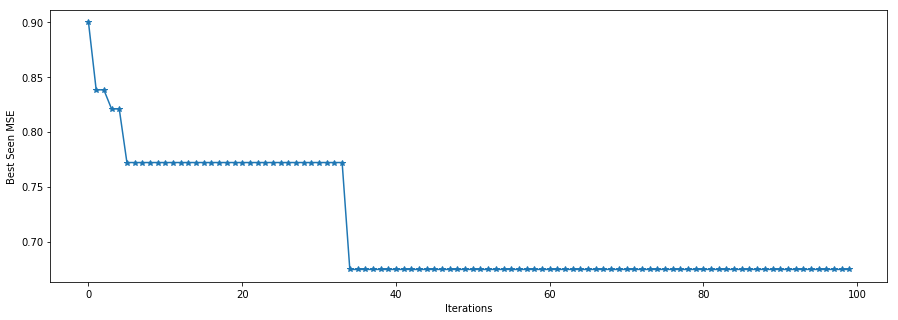

In [0]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-') 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
test_n = 0

test_gen = dataloader([df_test[test_n].values], look_back, shuffle=False)
size = df_test[test_n].shape[0]

batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, feature, look_back + 1)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

y_test = np.array(y_test).reshape(-1,4)
y_pred_all = y_pred_all.reshape(-1,4)

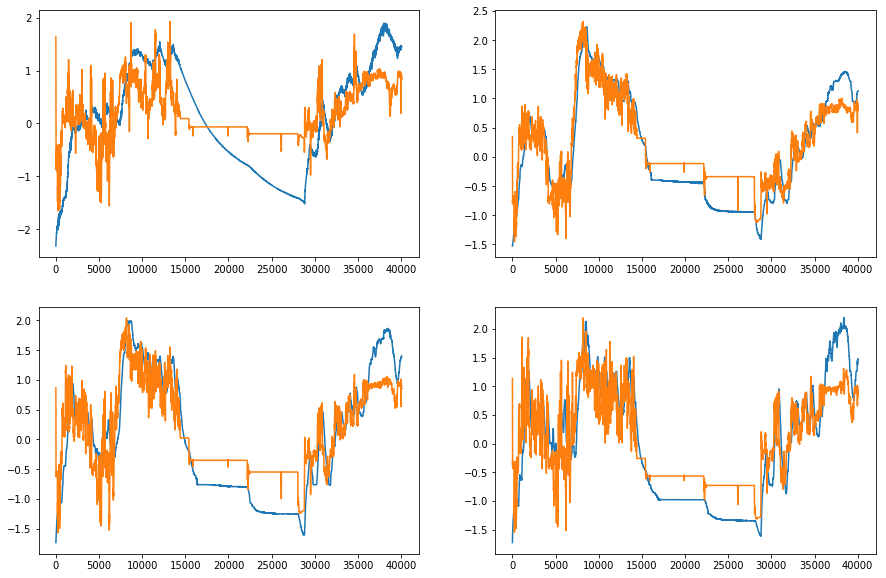

In [0]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(y_test[:size - look_back - 1,0])
plt.plot(y_pred_all[:size - look_back - 1,0])

plt.subplot(222)
plt.plot(y_test[:size - look_back - 1,1])
plt.plot(y_pred_all[:size - look_back - 1,1])

plt.subplot(223)
plt.plot(y_test[:size - look_back - 1,2])
plt.plot(y_pred_all[:size - look_back - 1,2])

plt.subplot(224)
plt.plot(y_test[:size - look_back - 1,3])
plt.plot(y_pred_all[:size - look_back - 1,3])
plt.show()


plt.show()

In [0]:
tot=0
for x in best_model.parameters():
    tot += np.prod(x.detach().cpu().numpy().shape)
    
print(tot)

3795


In [0]:
np.mean(np.abs((y_test-y_pred_all)**2))

0.3201788966795505

In [0]:
from sklearn.metrics import r2_score

In [0]:
r2_score(y_test[:,1:4], y_pred_all[:,1:4])

0.7742290237191226